###Install Packages

In [ ]:
!pip install yfinance

###Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

%matplotlib inline

###Latest S&P 500 Ticker List from Wikipedia

In [ ]:
wiki_ticker_list = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
for idx, symbol in enumerate(wiki_ticker_list['Symbol']):
  if symbol in ['BRK.B', 'BF.B']:
    wiki_ticker_list.loc[idx, 'Symbol'] = 'BRK-B' if symbol == 'BRK.B' else 'BF-B'
wiki_ticker_list

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


###Download Data from Yahoo Finance
We use, ^IRX as the risk free rate (11 month T-bill yield)

In [ ]:
sp500_data = yf.download(wiki_ticker_list['Symbol'].to_list() + ['^IRX'], start = '2003-09-30', end = '2023-09-30', auto_adjust = True, threads = True)
sp500_data = sp500_data.swaplevel(axis = 1)
sp500_data.head()

[*********************100%%**********************]  504 of 504 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1064894400, endDate = 1696046400")


,VLTO,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,^IRX
,Adj Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,,,,
2003-09-30 00:00:00,NaN,13.437275,NaN,0.314055,NaN,NaN,11.886888,3.674444,16.092518,19.663162,...,1461300,11822200,951400,NaN,2894671,2502694,832950,511300,NaN,0.0
2003-10-01 00:00:00,NaN,13.522359,NaN,0.315116,NaN,NaN,11.951141,3.713333,16.042091,19.867832,...,1355000,13500900,971200,NaN,5938179,1625546,429150,601700,NaN,0.0
2003-10-02 00:00:00,NaN,13.364345,NaN,0.311781,NaN,NaN,12.054499,3.716667,16.337433,19.802937,...,982700,8956800,1023000,NaN,3523959,1247330,332100,454700,NaN,0.0
2003-10-03 00:00:00,NaN,13.978168,NaN,0.328757,NaN,NaN,11.909231,3.715556,16.171759,20.401968,...,1510900,11383200,1933000,NaN,4017764,2290102,1138350,503900,NaN,0.0
2003-10-06 00:00:00,NaN,13.996399,NaN,0.337852,NaN,NaN,11.939968,3.744444,16.632774,20.486832,...,639600,7229000,783800,NaN,1974107,2374253,442200,305400,NaN,0.0


In [ ]:
date_index = pd.Series(sp500_data.index)
sp500_data.index = date_index.apply(lambda x : x.to_pydatetime().date())

In [ ]:
#Total number of stocks in the SP500 index

ticker_list = list(set(sp500_data.columns.get_level_values(0)))
ticker_list.remove('^IRX')
len(ticker_list)

503

###Principal Component Analysis

We use a subset of 50 stocks from the S&P 500 stock universe proportional to the relative weight of industries in the index.

In [ ]:
import random as random

pca_ticker_list = ['MMM','ABT','ADBE','AES','AXP','AMGN','AAPL','T','AZO','BA','KO','CL','CMCSA','CVS','DIS','EIX','LLY','EFX','EQR','XOM','F','BEN','GD','GE','GS','HAL','HON','IBM','INTC','IP','INTU','TGT','MCD','MSFT','MS','NKE','NUE','PFE','PNW','PRU','PHM','QCOM','DGX','SPGI','SPG','UPS','VZ','VMC','WMT','WFC']

In [ ]:
#calculating returns

price_df_500 = sp500_data.swaplevel(axis = 1).loc[:, 'Close']
volume_df_500 = sp500_data.swaplevel(axis = 1).loc[:, 'Volume']

returns_df_500 = price_df_500.copy()
returns_index = returns_df_500.index
returns_df_500.reset_index(drop = True, inplace = True)
returns_df_500 = (returns_df_500 / returns_df_500.shift(1)) - 1

In [ ]:
#calculating excess return (relative to 11 month T-bill yield)

excess_returns_df_500 = returns_df_500.copy()

for asset in excess_returns_df_500.columns:
  excess_returns_df_500.loc[:, asset] = excess_returns_df_500.loc[:, asset] - (price_df_500.reset_index(drop = True).loc[:, '^IRX'] * 0.01 * (1/252))

risk_free_df = price_df_500.loc[:, '^IRX'] * 0.01 * (1/252)
excess_returns_df_500.drop(columns = ['^IRX'], inplace = True)
price_df_500.drop(columns = ['^IRX'], inplace = True)
volume_df_500.drop(columns = ['^IRX'], inplace = True)

returns_df_500.set_index(returns_index, drop = True, inplace = True)
excess_returns_df_500.set_index(returns_index, drop = True, inplace = True)
risk_free_df

Date
2003-09-30    0.000037
2003-10-01    0.000036
2003-10-02    0.000036
2003-10-03    0.000036
2003-10-06    0.000036
                ...   
2023-09-25    0.000211
2023-09-26    0.000211
2023-09-27    0.000212
2023-09-28    0.000211
2023-09-29    0.000210
Name: ^IRX, Length: 5035, dtype: float64

####Cleaning Dataset for NaN values

In [ ]:
#Number of tickers to be dropped due to missing data

temp_df = excess_returns_df_500.isna().sum(axis = 0)
nan_ticker_list = []
for ticker in temp_df.index:
  if temp_df.loc[ticker] > 8:
    nan_ticker_list.append(ticker)
print(f'No. of tickers with missing data = {len(nan_ticker_list)}')

No. of tickers with missing data = 112


In [ ]:
returns_df_500.drop(columns = nan_ticker_list, axis = 1, inplace = True)
excess_returns_df_500.drop(columns = nan_ticker_list, axis = 1, inplace = True)

returns_df_500.dropna(axis = 0, inplace = True)
excess_returns_df_500.dropna(axis = 0, inplace = True)
risk_free_df = risk_free_df.loc[excess_returns_df_500.index]
risk_free_df

Date
2003-10-01    0.000036
2003-10-02    0.000036
2003-10-03    0.000036
2003-10-06    0.000036
2003-10-07    0.000036
                ...   
2023-09-25    0.000211
2023-09-26    0.000211
2023-09-27    0.000212
2023-09-28    0.000211
2023-09-29    0.000210
Name: ^IRX, Length: 5027, dtype: float64

In [ ]:
temp_df = excess_returns_df_500.isna().sum(axis = 0)
counter = 0
for ticker in temp_df.index:
  if temp_df.loc[ticker] > 0:
    counter += 1
print(f'No. of tickers with missing data = {counter}')

No. of tickers with missing data = 0


####PCA date Range - (2003-10-01 to 2015-09-30)

In [ ]:
price_df_500 = price_df_500.loc[excess_returns_df_500.index, excess_returns_df_500.columns]
price_df_500

,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2003-10-01,13.522359,0.315116,11.951141,3.713333,16.042091,19.867832,25.018597,8.499081,18.267344,8.587076,...,52.918961,11.140153,10.213856,7.197235,19.455219,19.842657,7.933932,48.991341,34.919998,40.665665
2003-10-02,13.364345,0.311781,12.054499,3.716667,16.337433,19.802937,25.355989,8.607634,18.501989,8.641834,...,52.585102,11.113918,10.406047,7.331894,19.564600,19.855774,7.941527,49.413528,35.380001,40.686775
2003-10-03,13.978168,0.328757,11.909231,3.715556,16.171759,20.401968,26.737438,8.582093,18.836481,9.035096,...,52.852200,11.076433,10.433507,7.294744,19.663565,20.223070,7.870600,49.862114,36.566666,40.679718
2003-10-06,13.996399,0.337852,11.939968,3.744444,16.632774,20.486832,26.737438,8.594862,18.821495,9.119723,...,52.752018,11.072681,10.488419,7.341179,19.840687,20.139992,7.911132,50.873596,36.666668,41.200924
2003-10-07,14.239498,0.351947,11.789105,3.731111,16.654390,20.611628,27.361309,8.677873,19.190945,9.209329,...,53.002434,11.076433,10.455471,7.239026,19.970900,20.310518,7.997258,50.389839,36.666668,41.546024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,111.714767,176.080002,96.933411,81.150002,315.680695,511.600006,175.429993,77.300003,240.020004,205.669998,...,213.050903,31.350000,90.650002,59.490002,116.230003,34.029751,124.970001,117.095718,228.149994,34.580002
2023-09-26,110.507202,171.960007,95.700241,81.260002,309.327057,506.299988,172.339996,76.070000,237.240005,201.660004,...,212.393539,31.020000,90.680000,57.720001,116.410004,34.448029,124.010002,112.216316,223.960007,33.990002
2023-09-27,110.277657,170.429993,95.004089,81.080002,313.081512,502.600006,172.809998,76.360001,242.630005,202.279999,...,210.770004,31.030001,92.209999,57.209999,120.199997,33.970001,121.980003,110.519997,225.910004,33.169998


In [ ]:
from numpy.random.mtrand import exponential
from datetime import datetime

pca_start_date, pca_end_date = datetime.strptime('2003-10-01', '%Y-%m-%d').date(), datetime.strptime('2015-09-30', '%Y-%m-%d').date()

returns_df_pca = returns_df_500.loc[pca_start_date : pca_end_date, pca_ticker_list]
excess_returns_df_pca = excess_returns_df_500.loc[pca_start_date : pca_end_date, pca_ticker_list]

#z-scoring excess returns
excess_returns_df_pca_z_scores = (excess_returns_df_pca - excess_returns_df_pca.mean(axis = 0))/(excess_returns_df_pca.std(axis = 0, ddof = 1))

###PCA

In [ ]:
from sklearn.decomposition import PCA

pca_decomposition = PCA(n_components = None, svd_solver = 'full', random_state = 42)
excess_returns_pca_full = pca_decomposition.fit_transform(excess_returns_df_pca_z_scores) #PCA on z-scores

In [ ]:
cum_var = 0
cum_var_list = np.cumsum(pca_decomposition.explained_variance_ratio_).tolist()
for component, value in enumerate(cum_var_list):
  if component > 9:
    break
  print(f'Cummulative explained variance component {component + 1} = {value * 100:.4f}%')

Cummulative explained variance component 1 = 45.8557%
Cummulative explained variance component 2 = 49.8076%
Cummulative explained variance component 3 = 52.5047%
Cummulative explained variance component 4 = 55.0389%
Cummulative explained variance component 5 = 57.0671%
Cummulative explained variance component 6 = 59.0076%
Cummulative explained variance component 7 = 60.7901%
Cummulative explained variance component 8 = 62.4875%
Cummulative explained variance component 9 = 64.0308%
Cummulative explained variance component 10 = 65.4810%


#### Percentage Variance explained by each PC

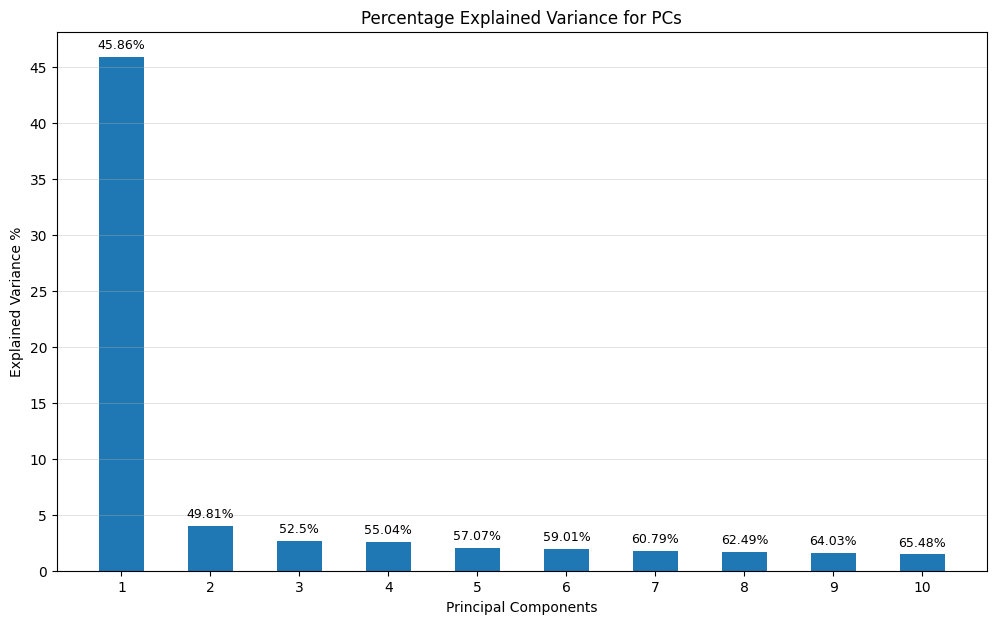

In [ ]:
fig, ax = plt.subplots(figsize = (12, 7))
ax.bar(range(1, 11), pca_decomposition.explained_variance_ratio_[:10] * 100, width = 0.5)
ax.set_title('Percentage Explained Variance for PCs')
ax.set_ylabel('Explained Variance %')
ax.set_xlabel('Principal Components')
ax.set_yticks(range(0, 50, 5))
ax.set_xticks(range(1,11))
ax.grid(True, alpha = 0.5, axis = 'y',linewidth = 0.5)

rects = ax.patches

for rect, label in zip(rects, cum_var_list[:10]):
  height = rect.get_height()
  ax.text(rect.get_x() + rect.get_width() / 2, height + 0.5, str(round(label * 100, 2)) + '%', ha = 'center', va = 'bottom', fontsize = 9)

In [ ]:
def num_components_by_var_ratio(pca_object, threshold = 0.7):
  var_ratio = np.cumsum(pca_object.explained_variance_ratio_)
  for idx, val in enumerate(var_ratio):
    if val > threshold:
      return idx + 1

n_factors = num_components_by_var_ratio(pca_decomposition)
n_factors

14

###We decide to use the first 5 principal components as the factors for our stochastic factor model

In [ ]:
pca_decomposition_5 = PCA(n_components = 1, svd_solver = 'full', random_state = 42)

#pca transformed returns a.k.a stochastic factors
excess_returns_pca_5 = pca_decomposition_5.fit_transform(excess_returns_df_pca_z_scores) #PCA-5 on z-scores
pca_components = n_factors = len(pca_decomposition_5.components_)

###Principal Component TS

In [ ]:
col_names = ['PC ' + str(idx + 1) for idx in range(pca_components)]
excess_returns_pca_5_df = pd.DataFrame(excess_returns_pca_5, index = excess_returns_df_pca_z_scores.index, columns = col_names)

#z-scoring the stochastic factors
excess_returns_pca_5_df_z_scores = (excess_returns_pca_5_df - excess_returns_pca_5_df.mean(axis = 0)) / excess_returns_pca_5_df.std(axis = 0, ddof = 1)
excess_returns_pca_5_df_z_scores

,PC 1
Date,
2003-10-01,1.791767
2003-10-02,0.121263
2003-10-03,0.734915
2003-10-06,0.103649
2003-10-07,0.419511
...,...
2015-09-24,-0.331139
2015-09-25,0.211866
2015-09-28,-1.905979


####Splitting excess returns into in-sample data and out-of-sample data

In [ ]:
excess_returns_df_500_LR = excess_returns_df_500.loc[pca_start_date:pca_end_date, :]

#z-scoring returns
excess_returns_df_500_LR_z_scores = (excess_returns_df_500_LR - excess_returns_df_500_LR.mean(axis = 0))/ excess_returns_df_500_LR.std(axis = 0, ddof = 1)

###Linear Regression

We perform a linear regression for each stock v/s the stochastic factors to calculate the factor loadings i.e. betas.

In [ ]:
from sklearn.linear_model import LinearRegression

regression_coef = []
linear_model = LinearRegression(fit_intercept=True)

X = excess_returns_pca_5_df_z_scores

for idx, ticker in enumerate(excess_returns_df_500_LR_z_scores.columns):
  y = excess_returns_df_500_LR_z_scores.loc[:, ticker]
  linear_model.fit(X,y)
  beta = list(linear_model.coef_)
  alpha = linear_model.intercept_
  regression_coef.append([alpha] + beta)

###Factor Loadings for Stocks

In [ ]:
factor_model_df = pd.DataFrame(regression_coef, index = excess_returns_df_500_LR_z_scores.columns, columns = ['alpha'] + [f'beta_{idx}' for idx in range(1, n_factors + 1)])
beta_df = factor_model_df.drop(columns = ['alpha'], axis = 1)
factor_model_df

,alpha,beta_1
A,7.250212e-18,0.690177
AAPL,-3.158842e-19,0.536326
ABT,2.027845e-18,0.557009
ACGL,1.376634e-17,0.626719
ACN,9.076997e-18,0.588556
...,...,...
XRAY,-5.987443e-18,0.665822
YUM,1.080570e-17,0.653465
ZBH,2.020937e-18,0.568737
ZBRA,-5.046745e-18,0.568652


In [ ]:
num_assets_in_portfolio = len(factor_model_df)
tickers_in_portfolio = excess_returns_df_500_LR_z_scores.columns

#Initialize weights
weights = np.array([(1.0/num_assets_in_portfolio) for i in range(num_assets_in_portfolio)])
print(f'No. of stocks in portfolio = {num_assets_in_portfolio}')

No. of stocks in portfolio = 391


In [ ]:
#calculate net portfolio beta
def portfolio_beta(weights, beta_df):
  weighted_portfolio_beta = np.multiply(weights.reshape(-1, 1), beta_df)
  net_portfolio_beta = weighted_portfolio_beta.sum(axis = 1).sum()
  return net_portfolio_beta

#beta squared
def portfolio_beta_sq(weights, beta_df):
  return portfolio_beta(weights, beta_df) ** 2

def covariance_matrix_using_PCA(betas):
  n_assets = num_assets_in_portfolio
  residual_covar, factor_covar = np.eye(n_assets), np.eye(n_factors)
  stock_pca_covar = np.dot(np.dot(betas, factor_covar), betas.T) + residual_covar
  return stock_pca_covar

stock_pca_covar = excess_returns_df_500.loc[pca_start_date:pca_end_date, :].cov(ddof = 1)

def portfolio_vol(weights):
  return np.dot(np.dot(weights, stock_pca_covar), weights.T)

#TARGET_VOL

TARGET_VOL = 0.06 / np.sqrt(252)

#contraints
constraints_vol = ({'type' : 'eq', 'fun' : lambda x : portfolio_vol(x) - TARGET_VOL})
constraints_wt = ({'type' : 'eq', 'fun' : lambda x : x.sum() - 1.0})


###Optimization

We minimize the square of the portfolio beta using an limited-memory BFGS optimization algorithm to calculate the beta neutral weights for the in-sample portfolio

In [ ]:
from scipy.optimize import minimize

sol = minimize(portfolio_beta_sq, weights, args = (beta_df), constraints=[constraints_vol, constraints_wt])
if sol.success:
  print(f'Solution Found, optimizer message = {sol.message}')
  beta_neutral_weights = sol.x
  print(f'Portfolio Beta = {portfolio_beta(beta_neutral_weights, beta_df)}')
  print(f'Porfolio Vol = {portfolio_vol(beta_neutral_weights) * 100 * np.sqrt(252):.4f}%')
  print(f'Portfolio Weights Sum = {beta_neutral_weights.sum():.4f}')

else:
  print(f'Solution not found, optimizer message = {sol.message}')

Solution Found, optimizer message = Optimization terminated successfully
Portfolio Beta = 1.907496931852215e-05
Porfolio Vol = 6.0000%
Portfolio Weights Sum = 1.0000


###Beta Neutral Weights

In [ ]:
long_positions = short_positions = 0
for weight in beta_neutral_weights:
  if weight > 0:
    long_positions += 1
  elif weight < 0:
    short_positions += 1
print(f'No. of long positions = {long_positions}')
print(f'No. of short positions = {short_positions}')
print(f'Total positions = {long_positions + short_positions}')
print(f'Total stocks = {num_assets_in_portfolio}')

No. of long positions = 186
No. of short positions = 205
Total positions = 391
Total stocks = 391


###Beta-Neutral Portfolio Factor Exposures (aggregate)

In [ ]:
beta_neutral_portfolio_factor_exposure = np.multiply(beta_neutral_weights.reshape(-1, 1), factor_model_df).sum(axis = 0)
beta_neutral_portfolio_factor_exposure

alpha    -1.308188e-17
beta_1    1.907497e-05
dtype: float64

In [ ]:
weighted_returns = beta_neutral_weights.reshape(1, -1) * excess_returns_df_500_LR_z_scores
bn_port_returns = weighted_returns.sum(axis = 1)
bn_port_returns

Date
2003-10-01   -1.296594
2003-10-02    1.043208
2003-10-03    0.680841
2003-10-06    1.225486
2003-10-07    0.350435
                ...   
2015-09-24   -0.496120
2015-09-25   -2.376388
2015-09-28   -1.590665
2015-09-29   -1.131723
2015-09-30   -0.167119
Length: 3016, dtype: float64

####Beta Neutral Portfolio Factor Exposures (Regression)

In [ ]:
y = bn_port_returns
X = excess_returns_pca_5_df_z_scores
linear_model.fit(X, y)
print(f'alpha = {linear_model.intercept_}')
print(f'betas = {linear_model.coef_}')

alpha = -1.1234732165281828e-23
betas = [1.90749693e-05]


###Out of Sample Analysis

In [ ]:
#Out of sample data
out_of_sample_returns = excess_returns_df_500.loc[pca_end_date:,:]
out_of_sample_returns = out_of_sample_returns.iloc[1:, :]
#z-scoring using in-sample mean and standard deviation
insample_mean, insample_std = excess_returns_df_500_LR.mean(axis = 0), excess_returns_df_500_LR.std(axis = 0, ddof = 1)

#z-scoring out of sample returns
out_of_sample_returns_z_scores = (out_of_sample_returns - insample_mean)/insample_std

###Calculating out of sample factors

In [ ]:
#pca transform for out of sample returns

out_of_sample_factors = pca_decomposition_5.transform(out_of_sample_returns_z_scores.loc[:, pca_ticker_list])

col_names = ['PC ' + str(idx + 1) for idx in range(pca_components)]
oos_factor_df = pd.DataFrame(out_of_sample_factors, index = out_of_sample_returns_z_scores.index, columns = col_names)
oos_factor_df_z_scores = (oos_factor_df - oos_factor_df.mean(axis = 0))/oos_factor_df.std(axis = 0, ddof = 1)

### Out of sample factor loadings i.e. betas

In [ ]:
regression_coef = []
linear_model = LinearRegression(fit_intercept=True)

X = oos_factor_df_z_scores

for idx, ticker in enumerate(out_of_sample_returns_z_scores.columns):
  y = out_of_sample_returns_z_scores.loc[:, ticker]
  linear_model.fit(X,y)
  beta = list(linear_model.coef_)
  alpha = linear_model.intercept_
  regression_coef.append([alpha] + beta)

In [ ]:
oos_factor_model_df = pd.DataFrame(regression_coef, index = out_of_sample_returns_z_scores.columns, columns = ['alpha'] + [f'beta_{idx}' for idx in range(1, n_factors + 1)])
beta_df = factor_model_df.drop(columns = ['alpha'], axis = 1)
oos_factor_model_df

,alpha,beta_1
A,0.011574,0.528559
AAPL,-0.026616,0.541064
ABT,0.016399,0.794438
ACGL,0.001591,0.879029
ACN,0.003164,0.732027
...,...,...
XRAY,-0.024709,0.716584
YUM,-0.011722,0.565743
ZBH,-0.002865,0.636657
ZBRA,0.021816,0.742297


###Out of sample beta-neutral portfolio exposure (aggregate)

In [ ]:
oos_portfolio_beta_exposure = np.multiply(beta_neutral_weights.reshape(-1, 1), oos_factor_model_df).sum(axis = 0)
oos_portfolio_beta_exposure

alpha    -0.008904
beta_1   -0.528512
dtype: float64

In [ ]:
weighted_out_of_sample_returns = beta_neutral_weights.reshape(1, -1) * out_of_sample_returns
weighted_oos_port_returns = weighted_out_of_sample_returns.sum(axis = 1)
weighted_oos_port_returns

Date
2015-10-01    0.018210
2015-10-02    0.046975
2015-10-05    0.037488
2015-10-06   -0.011220
2015-10-07    0.047421
                ...   
2023-09-25    0.025827
2023-09-26   -0.001321
2023-09-27    0.028904
2023-09-28    0.054944
2023-09-29   -0.000479
Length: 2011, dtype: float64

In [ ]:
weighted_oos_port_returns_z_scores = (weighted_oos_port_returns - weighted_oos_port_returns.mean(axis = 0)) / weighted_oos_port_returns.std(axis = 0, ddof = 1)

###Out of sample beta-neutral portfolio factor exposure (regression)

In [ ]:
X = oos_factor_df
y = weighted_oos_port_returns_z_scores
linear_model.fit(X, y)
print(f'Alpha : {linear_model.intercept_}')
print(f'Betas : {linear_model.coef_}')

Alpha : 0.0027449960202182086
Betas : [0.13912084]


### Simulator

In [ ]:
from sklearn.decomposition import PCA
from scipy.optimize import minimize

class SimulateStrategy(object):

  def __init__(self, beta_neutral_weights, price_df, returns_df, excess_returns_df):
    self.beta_neutral_wts = beta_neutral_weights
    self.price_df = price_df
    self.returns_df = returns_df
    self.excess_returns_df = excess_returns_df
    self.dates = excess_returns_df.index.to_series().reset_index(drop = True)
    self.pca_start_date, self.pca_end_date = pca_start_date, pca_end_date
    self.stock_covar = stock_pca_covar
    self.transaction_costs = 0

    self.n_assets, self.n_factors = num_assets_in_portfolio, n_factors

    self.pca_excess_returns_df = self.excess_returns_df.loc[pca_start_date: pca_end_date, pca_ticker_list]
    self.pca_window_len = len(self.pca_excess_returns_df)

    self.linear_model = LinearRegression(fit_intercept = True, n_jobs=-1)

  def _return_z_score(self, df):
    mean, std = df.mean(axis = 0), df.std(axis = 0, ddof = 1)
    return (df - mean) / std

  def _calc_portfolio_beta(self, weights):
    weighted_portfolio_beta = np.multiply(weights.reshape(-1, 1), self.betas)
    net_portfolio_beta = weighted_portfolio_beta.sum(axis = 1).sum()
    return net_portfolio_beta

  def _calc_portfolio_beta_sq(self, weights):
    return self._calc_portfolio_beta(weights) ** 2

  def _calc_portfolio_value(self, prices):
    portfolio_value = np.multiply(self.beta_neutral_wts, prices).sum()
    return portfolio_value

  def num_components_by_var_ratio(self, pca_object, threshold = 0.6):
    var_ratio = np.cumsum(pca_object.explained_variance_ratio_)
    for idx, val in enumerate(var_ratio):
      if val > threshold:
        return idx + 1

  def _covariance_matrix_using_PCA(self, betas, pca_factors_arr):
    pca_factor_df = pd.DataFrame(pca_factors_arr, columns = list(range(1,self.n_factors + 1)))
    residual_covar, factor_covar = np.eye(self.n_assets), np.eye(self.n_factors)
    stock_pca_covar = np.dot(np.dot(betas, factor_covar), betas.T) + residual_covar
    return stock_pca_covar

  def portfolio_vol(self, weights):
    return np.dot(np.dot(weights, self.stock_covar), weights.T)

  def _recalibrate_betas(self, start_date, end_date):
    self.pca_excess_returns_df = self.excess_returns_df.loc[start_date:end_date, pca_ticker_list]
    self.pca_excess_returns_df_z_scores = self._return_z_score(self.pca_excess_returns_df)


    self.pca_5 = PCA(n_components=1, svd_solver = 'full', random_state = 42)

    self.principal_comps = self.pca_5.fit_transform(self.pca_excess_returns_df_z_scores)
    self.principal_comps_z_scores = self._return_z_score(self.principal_comps)
    self.excess_returns_df_LR = self.excess_returns_df.loc[start_date:end_date, :]
    self.excess_returns_df_LR_z_scores = self._return_z_score(self.excess_returns_df_LR)
    self.stock_covar = self.excess_returns_df_LR_z_scores.cov(ddof = 1)

    self.n_factors = len(self.pca_5.components_)

    self.regression_coef = []
    X = self.principal_comps_z_scores
    for idx, ticker in enumerate(self.excess_returns_df_LR_z_scores):
      y = self.excess_returns_df_LR_z_scores.loc[:, ticker]
      self.linear_model.fit(X, y)
      beta = list(self.linear_model.coef_)
      alpha = self.linear_model.intercept_
      self.regression_coef.append([alpha] + beta)

    self.factor_df = pd.DataFrame(self.regression_coef, index = self.excess_returns_df_LR_z_scores.columns, columns = ['alpha'] + [f'beta_{i}' for i in range(1, self.n_factors + 1)])
    self.betas = self.factor_df.drop(columns = ['alpha'], axis = 1)
    self.stock_covar_using_pca = self._covariance_matrix_using_PCA(self.betas, self.principal_comps_z_scores)

  def _calc_beta_neutral_weights(self):
    constraints_vol_upper = ({'type' : 'eq', 'fun' : lambda x : self.portfolio_vol(x) - TARGET_VOL})
    constraints_wt = ({'type' : 'eq', 'fun' : lambda x : x.sum() - 1.0})
    solver = minimize(self._calc_portfolio_beta_sq, self.beta_neutral_wts, constraints=[constraints_vol, constraints_wt])
    if solver.success:
      self.beta_neutral_wts = solver.x
    else:
      raise RuntimeError(f'Solver failed to converge : {solver.message}')

  def _rebalance_portfolio(self, prices):
    self.trade_quantities = self.beta_neutral_wts - self.previous_weights
    self.trade_values = np.multiply(self.trade_quantities, prices)
    self.cumm_trade_val = np.absolute(self.trade_values).sum()
    self.transaction_costs += (self.cumm_trade_val * 0.0025)

  def _calculate_portfolio_pnl(self):
    self.pnl = self.curr_portfolio_val - self.prev_portfolio_val

  def annualized_returns(self, df):
    return (df.mean(axis = 0) * 252)

  def annualized_volatility(self, df):
    return (df.std(axis = 0, ddof = 1) * np.sqrt(252))

  def max_drawdown(self, df):
    max_val, max_dd = float('-inf'), 0.0
    for val in df.values:
      if val > max_val:
        max_val = val
      dd = (max_val - val)/max_val if max_val > float('-inf') else 0.0
      if dd > max_dd:
        dd = max_dd
    return max_dd

  def simulate(self):
    self.pca_start_index, self.pca_end_index = self.dates[self.dates == self.pca_start_date].index, self.dates[self.dates == self.pca_end_date].index
    self.prev_portfolio_val, self.curr_portfolio_val = 0, self._calc_portfolio_value(self.price_df.loc[self.pca_end_date, :])
    self.portfolio_values, self.portfolio_weights = [], []
    self.sim_date_index = self.pca_end_index + 1
    self.sim_date = self.dates.iloc[self.sim_date_index].values[-1]
    self.current_month = self.sim_date.month

    while(self.sim_date_index + 1 < len(self.dates)):
      self.sim_date_index += 1
      self.sim_date = self.dates.iloc[self.sim_date_index].values[-1]
      self.current_prices = self.price_df.loc[self.sim_date, :]
      self.prev_portfolio_val = self.curr_portfolio_val

      if self.sim_date.month != self.current_month:
        self.current_month = self.sim_date.month
        self.pca_end_date, self.pca_start_date = self.dates.iloc[self.sim_date_index - 1].values[-1], self.dates.iloc[self.sim_date_index - self.pca_window_len].values[-1]
        self.previous_weights = self.beta_neutral_wts

        self._recalibrate_betas(self.pca_start_date, self.pca_end_date)
        self._calc_beta_neutral_weights()

      self.curr_portfolio_val = self._calc_portfolio_value(self.current_prices)
      self.portfolio_values.append((self.sim_date, self.curr_portfolio_val))
      self.portfolio_weights.append((self.sim_date, self.beta_neutral_wts))

    self.portfolio_values_df = pd.DataFrame(self.portfolio_values, columns = ['Date', 'Portfolio Value'])
    self.portfolio_weights_df = pd.DataFrame(self.portfolio_weights, columns = ['Date', 'Portfolio Weights'])

    self.portfolio_values_df.set_index(pd.to_datetime(self.portfolio_values_df['Date']), inplace = True)
    self.portfolio_weights_df.set_index(pd.to_datetime(self.portfolio_weights_df['Date']), inplace = True)
    self.portfolio_values_df.drop(['Date'], axis = 1, inplace = True)
    self.portfolio_weights_df.drop(['Date'], axis = 1, inplace = True)

    self.portfolio_cumm_returns_df = (self.portfolio_values_df / self.portfolio_values_df.iloc[0]) - 1
    self.portfolio_returns_df = (self.portfolio_values_df/self.portfolio_values_df.shift(1)) - 1
    self.portfolio_returns_df.rename(columns = {'Portfolio Value' : 'Portfolio Return'}, inplace = True)
    self.portfolio_cumm_returns_df.rename(columns = {'Portfolio Value' : 'Cummulative Return'}, inplace = True)

    self.ann_ret, self.ann_vol, self.max_dd = self.annualized_returns(self.portfolio_returns_df['Portfolio Return']), self.annualized_volatility(self.portfolio_returns_df['Portfolio Return']), self.max_drawdown(self.portfolio_values_df['Portfolio Value'])

    self.portfolio_metrics = {
        'Annualized Return' : self.ann_ret,
        'Annualized Volatility' : self.ann_vol,
        'Max Drawdown' : self.max_dd
    }

    print('Simulation Completed')


#Backtesting

In [ ]:
simulator = SimulateStrategy(beta_neutral_weights, price_df_500, returns_df_500, excess_returns_df_500)

try:
  simulator.simulate()

except RuntimeError as exp:
  print(exp)

Simulation Completed


In [ ]:
strategy_cumm_returns = simulator.portfolio_cumm_returns_df
strategy_cumm_returns

,Cummulative Return
Date,
2015-10-02,0.000000
2015-10-05,-0.004152
2015-10-06,-0.049980
2015-10-07,-0.021524
2015-10-08,-0.035669
...,...
2023-09-25,2.783628
2023-09-26,2.761622
2023-09-27,2.805760


In [ ]:
risk_free_df = risk_free_df.reindex(pd.to_datetime(risk_free_df.index))
risk_free_df = risk_free_df.loc[strategy_cumm_returns.index]
strategy_cumm_returns = strategy_cumm_returns['Cummulative Return']
strategy_excess_daily_returns = simulator.portfolio_returns_df['Portfolio Return'] - risk_free_df
strategy_cumm_returns

Date
2015-10-02    0.000000
2015-10-05   -0.004152
2015-10-06   -0.049980
2015-10-07   -0.021524
2015-10-08   -0.035669
                ...   
2023-09-25    2.783628
2023-09-26    2.761622
2023-09-27    2.805760
2023-09-28    2.901275
2023-09-29    2.866884
Name: Cummulative Return, Length: 2010, dtype: float64

In [ ]:
strategy_sharpe_ratio = (strategy_excess_daily_returns.mean() / strategy_excess_daily_returns.std(ddof = 1)) * np.sqrt(252)
strategy_sortino_ratio = (strategy_excess_daily_returns.mean() / strategy_excess_daily_returns.apply(lambda x : 0 if x > 0 else x).std(ddof = 1)) * np.sqrt(252)

print(f'Strategy Sharpe Ratio = {strategy_sharpe_ratio:.4f}')
print(f'Strategy Sortino Ratio = {strategy_sortino_ratio:.4f}')

Strategy Sharpe Ratio = 0.5700
Strategy Sortino Ratio = 0.9061


In [ ]:
benchmark_sp500 = yf.download('^SPX', start = '2003-09-30', end = '2023-09-30', auto_adjust = True)['Close']
benchmark_sp500 = benchmark_sp500.reindex(pd.to_datetime(benchmark_sp500.index))
benchmark_sp500 = benchmark_sp500.loc[strategy_excess_daily_returns.index]

benchmark_sp500_daily_returns = (benchmark_sp500 / benchmark_sp500.shift(1)) - 1.0
benchmark_sp500_cumm_returns = (benchmark_sp500 / benchmark_sp500.iloc[0]) - 1.0

benchmark_sp500_cumm_returns = benchmark_sp500_cumm_returns.loc[strategy_excess_daily_returns.index]
benchmark_sp500_daily_returns = benchmark_sp500_daily_returns.loc[strategy_excess_daily_returns.index]

benchmark_sp500_cumm_returns

[*********************100%%**********************]  1 of 1 completed


Date
2015-10-02    0.000000
2015-10-05    0.018290
2015-10-06    0.014636
2015-10-07    0.022789
2015-10-08    0.031809
                ...   
2023-09-25    1.222778
2023-09-26    1.190026
2023-09-27    1.190529
2023-09-28    1.203438
2023-09-29    1.197467
Name: Close, Length: 2010, dtype: float64

In [ ]:
benchmark_bond = yf.download('AGG', start = '2003-09-30', end = '2023-09-30', auto_adjust = True)['Close']
benchmark_bond = benchmark_bond.reindex(pd.to_datetime(benchmark_bond.index))

benchmark_bond_daily_returns = (benchmark_bond / benchmark_bond.shift(1)) - 1.0
benchmark_cumm_bond_returns = ((benchmark_bond / benchmark_bond.iloc[0]) - 1.0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
benchmark_daily_excess_returns = benchmark_sp500_daily_returns - risk_free_df
benchmark_sp500_cumm_returns

Date
2015-10-02    0.000000
2015-10-05    0.018290
2015-10-06    0.014636
2015-10-07    0.022789
2015-10-08    0.031809
                ...   
2023-09-25    1.222778
2023-09-26    1.190026
2023-09-27    1.190529
2023-09-28    1.203438
2023-09-29    1.197467
Name: Close, Length: 2010, dtype: float64

In [ ]:
benchmark_sharpe_ratio = (benchmark_daily_excess_returns.mean() / benchmark_daily_excess_returns.std(ddof = 1)) * np.sqrt(252)
benchmark_sortino_ratio = (benchmark_daily_excess_returns.mean() / benchmark_daily_excess_returns.apply(lambda x : 0 if x > 0 else x).std(ddof = 1)) * np.sqrt(252)

print(f'Benchmark Sharpe Ratio = {benchmark_sharpe_ratio:.4f}')
print(f'Benchmark Sortino Ratio = {benchmark_sortino_ratio:.4f}')

Benchmark Sharpe Ratio = 0.5467
Benchmark Sortino Ratio = 0.8365


In [ ]:
strategy_vs_benchmark = strategy_excess_daily_returns - benchmark_daily_excess_returns
strategy_vs_benchmark_cumm = (1 + strategy_vs_benchmark).cumprod() - 1

excess_sharpe_ratio = (strategy_vs_benchmark.mean() / strategy_vs_benchmark.std(ddof = 1)) * np.sqrt(252)
excess_sortino_ratio = (strategy_vs_benchmark.mean() / strategy_vs_benchmark.apply(lambda x : 0 if x > 0 else x).std(ddof = 1)) * np.sqrt(252)

print(f'Excess Sharpe Ratio = {excess_sharpe_ratio:.4f}')
print(f'Excess Sortino Ratio = {excess_sortino_ratio:.4f}')

Excess Sharpe Ratio = 0.4396
Excess Sortino Ratio = 0.7225


In [ ]:
strat_ann_ret, strat_ann_vol= simulator.annualized_returns(strategy_excess_daily_returns), simulator.annualized_volatility(strategy_excess_daily_returns)

print(f'Strategy Annualized Returns = {strat_ann_ret * 100:.4f}')
print(f'Strategy Annualized Volatility = {strat_ann_vol * 100:.4f}')

Strategy Annualized Returns = 26.2113
Strategy Annualized Volatility = 45.9821


In [ ]:
benchmark_ann_ret, benchmark_ann_vol= simulator.annualized_returns(benchmark_daily_excess_returns), simulator.annualized_volatility(benchmark_daily_excess_returns)

print(f'Benchmark Annualized Returns = {benchmark_ann_ret * 100:.4f}')
print(f'Benchmark Annualized Volatility = {benchmark_ann_vol * 100:.4f}')

Benchmark Annualized Returns = 10.2228
Benchmark Annualized Volatility = 18.7007


In [ ]:
excess_ann_ret, excess_ann_vol = simulator.annualized_returns(strategy_vs_benchmark), simulator.annualized_volatility(strategy_vs_benchmark)

print(f'Excess Annualized Returns = {excess_ann_ret * 100:.4f}')
print(f'Excess Annualized Volatility = {excess_ann_vol * 100:.4f}')

Excess Annualized Returns = 15.9885
Excess Annualized Volatility = 36.3695


#Results

In [ ]:
def calc_drawdown(portfolio_val):
  max_val, max_dd, dd = 0.0, 0.0, 0.0
  for val in portfolio_val.values:
    max_val = max(max_val, val)
    dd = ((max_val - val)/max_val)
    max_dd = max(max_dd, dd)
  return max_dd

In [ ]:
strategy_max_dd = calc_drawdown(simulator.portfolio_values_df['Portfolio Value'])
benchmark_max_dd = calc_drawdown(benchmark_sp500)
print(f'Strategy Max DD = {strategy_max_dd * 100:.4f}%')
print(f'Benchmark Max DD = {benchmark_max_dd * 100:.4f}%')

Strategy Max DD = 64.7854%
Benchmark Max DD = 33.9250%


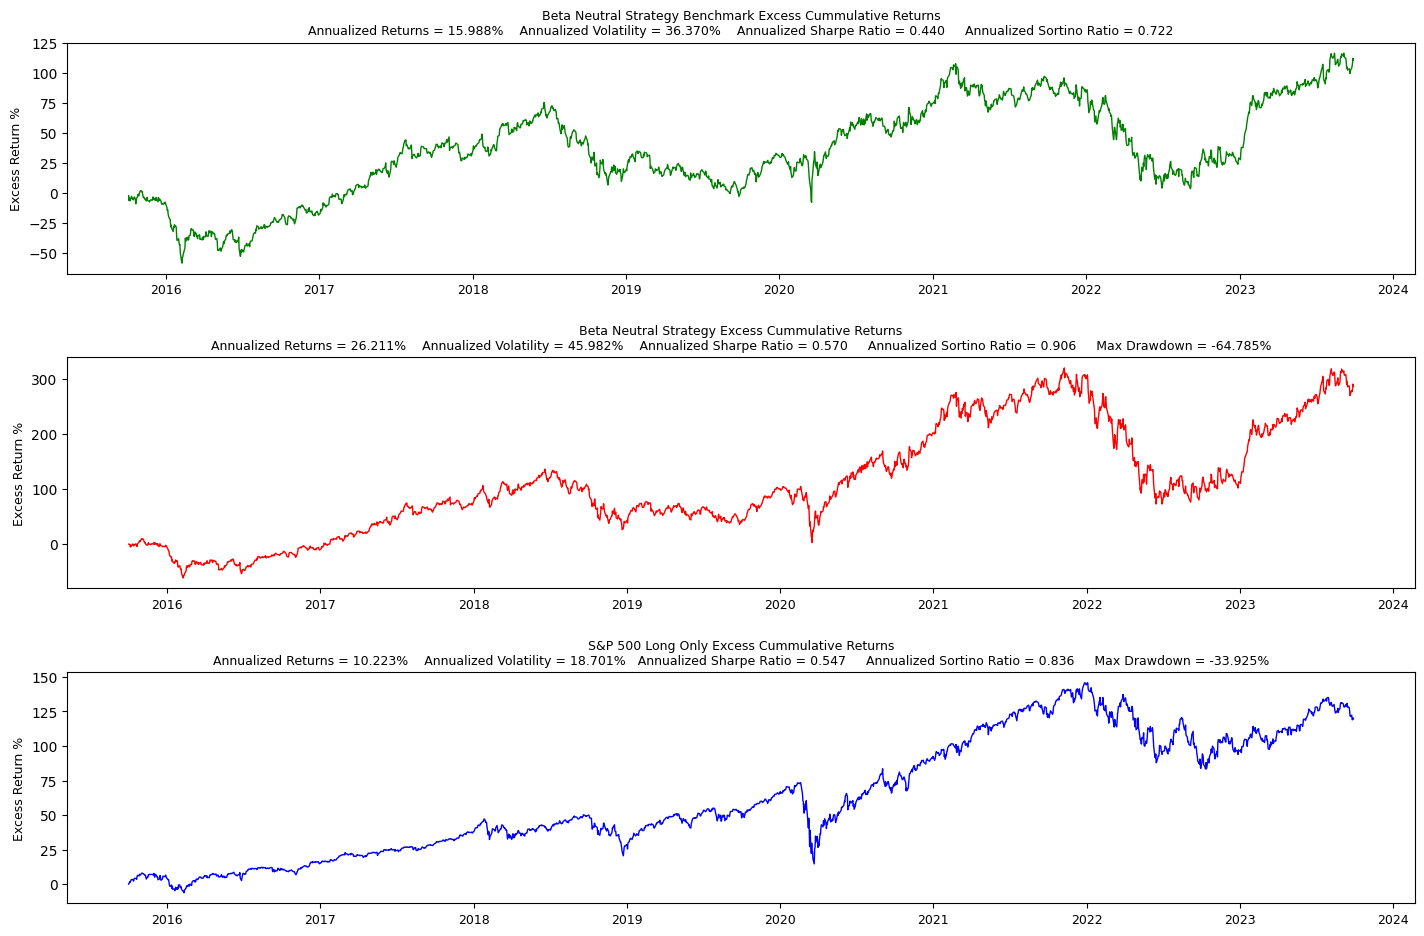

In [ ]:
fig, axs = plt.subplots(3, figsize = (15, 10))
plt.rc('xtick', labelsize=9)
fig.tight_layout(pad = 4.0)

axs[0].plot(strategy_vs_benchmark_cumm * 100, label = 'Strategy Benchmark Excess Cummulative Returns', color = 'green', linewidth = 1)
axs[0].set_ylabel('Excess Return %', fontsize = 9)
axs[0].set_title(f'Beta Neutral Strategy Benchmark Excess Cummulative Returns\nAnnualized Returns = {excess_ann_ret * 100:.3f}%    Annualized Volatility = {excess_ann_vol * 100:.3f}%    Annualized Sharpe Ratio = {excess_sharpe_ratio:.3f}     Annualized Sortino Ratio = {excess_sortino_ratio:.3f}', fontsize = 9)
axs[1].plot(strategy_cumm_returns * 100, label = 'Strategy Excess Cummulative Returns', color = 'red', linewidth = 1)
axs[1].set_ylabel('Excess Return %', fontsize = 9)
axs[1].set_title(f'Beta Neutral Strategy Excess Cummulative Returns\nAnnualized Returns = {strat_ann_ret * 100:.3f}%    Annualized Volatility = {strat_ann_vol * 100:.3f}%    Annualized Sharpe Ratio = {strategy_sharpe_ratio:.3f}     Annualized Sortino Ratio = {strategy_sortino_ratio:.3f}     Max Drawdown = -{strategy_max_dd * 100:.3f}%', fontsize = 9)
axs[2].plot(benchmark_sp500_cumm_returns * 100, label = 'S&P 500 Long Only Excess Cummulative Returns', color = 'blue', linewidth = 1)
axs[2].set_ylabel('Excess Return %', fontsize = 9)
axs[2].set_title(f'S&P 500 Long Only Excess Cummulative Returns\nAnnualized Returns = {benchmark_ann_ret * 100:.3f}%    Annualized Volatility = {benchmark_ann_vol* 100:.3f}%   Annualized Sharpe Ratio = {benchmark_sharpe_ratio:.3f}     Annualized Sortino Ratio = {benchmark_sortino_ratio:.3f}     Max Drawdown = -{benchmark_max_dd * 100:.3f}%', fontsize = 9)
plt.show()

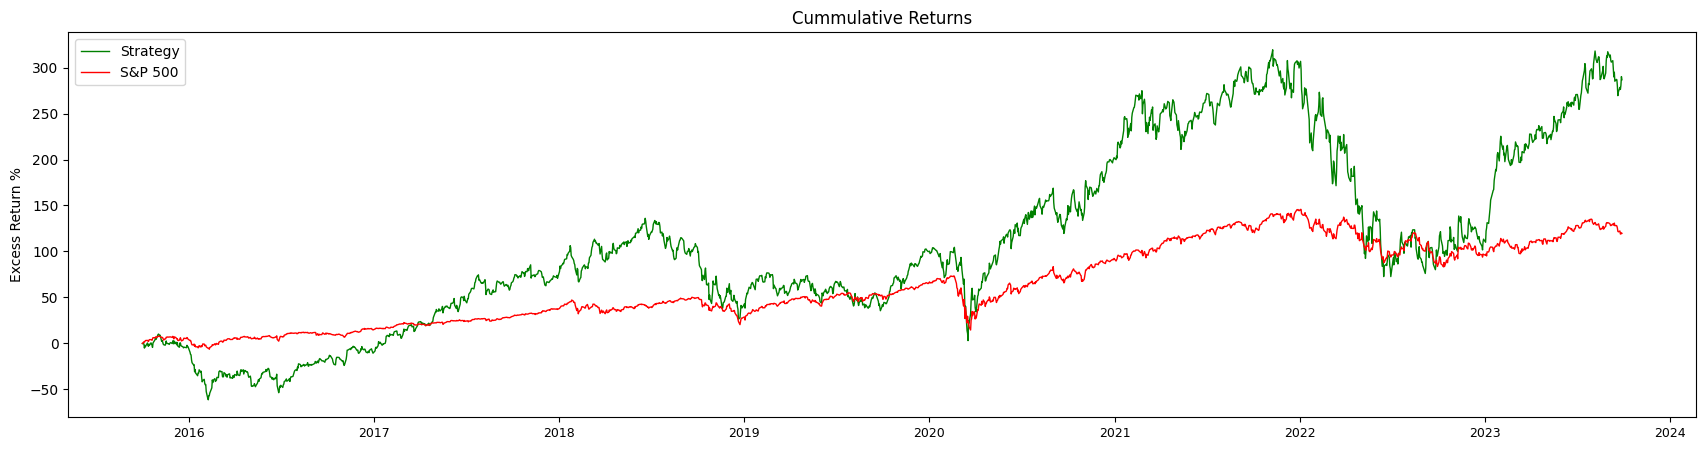

In [ ]:
plt.figure(figsize = (21,5))
plt.plot(strategy_cumm_returns * 100, label = 'Strategy', color = 'green', linewidth = 1)
plt.plot(benchmark_sp500_cumm_returns * 100, label = 'S&P 500', color = 'red', linewidth = 1)
plt.title('Cummulative Returns')
plt.ylabel('Excess Return %')
plt.legend(loc = 'best')
plt.show()

In [ ]:
bond_idx_excess_returns = (benchmark_bond_daily_returns - risk_free_df).dropna()
bond_idx_excess_returns

Date
2015-10-02    0.003015
2015-10-05   -0.003735
2015-10-06    0.002468
2015-10-07   -0.000729
2015-10-08   -0.001369
                ...   
2023-09-25   -0.008101
2023-09-26   -0.001484
2023-09-27   -0.003715
2023-09-28    0.002773
2023-09-29   -0.001166
Length: 2010, dtype: float64

In [ ]:
daily_returns_df = pd.concat([strategy_excess_daily_returns, benchmark_daily_excess_returns], axis = 1)
daily_returns_df.rename(columns = {0 : 'Strategy Excess Returns', 1 : 'Benchmark Excess Returns'}, inplace = True)
daily_returns_df.dropna(axis = 0, inplace = True)
daily_returns_df

,Strategy Excess Returns,Benchmark Excess Returns
Date,,
2015-10-05,-0.004153,0.018290
2015-10-06,-0.046019,-0.003588
2015-10-07,0.029953,0.008035
2015-10-08,-0.014457,0.008818
2015-10-09,0.013071,0.000725
...,...,...
2023-09-25,0.013174,0.003812
2023-09-26,-0.006028,-0.014946
2023-09-27,0.011522,0.000018


## Out of Sample Sensitivity to S&P 500 and US Aggregate Bond Index

In [ ]:
X = pd.concat([bond_idx_excess_returns, benchmark_daily_excess_returns], axis = 1, join = 'inner').dropna(axis = 0)
y = strategy_excess_daily_returns.loc[X.index]

linear_model = LinearRegression(fit_intercept = True)
linear_model.fit(X, y)

beta_list = list(linear_model.coef_)
alpha = linear_model.intercept_

print(f'Strategy Alpha = {alpha:.4f}')
print(f'Strategy Bond Beta = {beta_list[0]:.4f}')
print(f'Strategy Stock Beta = {beta_list[1]:.4f}')

Strategy Alpha = 0.0004
Strategy Bond Beta = 0.5581
Strategy Stock Beta = 1.6166


#Portfolio Weights

In [ ]:
weights_df = pd.DataFrame([], index = simulator.portfolio_weights_df.index, columns = excess_returns_df_500.columns, dtype = float)

for idx, weight_list in enumerate(simulator.portfolio_weights_df['Portfolio Weights']):
  for idx2, weight in enumerate(weight_list):
    weights_df.iloc[idx, idx2] = weight

weights_df

,A,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,ADSK,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-02,-0.002403,0.020657,-0.026655,-0.029368,-0.009579,0.000147,-0.001775,0.006591,-0.056113,0.021905,...,-0.002702,-0.013461,0.064049,-0.048430,-0.04776,-0.029969,-0.021011,-0.005335,0.010334,0.067553
2015-10-05,-0.002403,0.020657,-0.026655,-0.029368,-0.009579,0.000147,-0.001775,0.006591,-0.056113,0.021905,...,-0.002702,-0.013461,0.064049,-0.048430,-0.04776,-0.029969,-0.021011,-0.005335,0.010334,0.067553
2015-10-06,-0.002403,0.020657,-0.026655,-0.029368,-0.009579,0.000147,-0.001775,0.006591,-0.056113,0.021905,...,-0.002702,-0.013461,0.064049,-0.048430,-0.04776,-0.029969,-0.021011,-0.005335,0.010334,0.067553
2015-10-07,-0.002403,0.020657,-0.026655,-0.029368,-0.009579,0.000147,-0.001775,0.006591,-0.056113,0.021905,...,-0.002702,-0.013461,0.064049,-0.048430,-0.04776,-0.029969,-0.021011,-0.005335,0.010334,0.067553
2015-10-08,-0.002403,0.020657,-0.026655,-0.029368,-0.009579,0.000147,-0.001775,0.006591,-0.056113,0.021905,...,-0.002702,-0.013461,0.064049,-0.048430,-0.04776,-0.029969,-0.021011,-0.005335,0.010334,0.067553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,-0.010252,0.025371,-0.028161,-0.036926,-0.017538,-0.001525,-0.005385,0.004035,-0.073544,0.023693,...,-0.001536,-0.025023,0.074971,-0.048108,-0.06132,-0.033090,-0.023556,-0.005038,0.016788,0.073085
2023-09-26,-0.010252,0.025371,-0.028161,-0.036926,-0.017538,-0.001525,-0.005385,0.004035,-0.073544,0.023693,...,-0.001536,-0.025023,0.074971,-0.048108,-0.06132,-0.033090,-0.023556,-0.005038,0.016788,0.073085
2023-09-27,-0.010252,0.025371,-0.028161,-0.036926,-0.017538,-0.001525,-0.005385,0.004035,-0.073544,0.023693,...,-0.001536,-0.025023,0.074971,-0.048108,-0.06132,-0.033090,-0.023556,-0.005038,0.016788,0.073085


In [ ]:
final_portfolio_value = (1 + simulator.portfolio_cumm_returns_df['Cummulative Return'].iloc[-1] * 100)
final_portfolio_value

287.68838497507426